import tensorflow as tf # !pip install tensorflow
print(tf.version.VERSION)
import tensorflow_hub as hub #!pip install tensorflow-hub
print(hub.__version__)
import tensorflow_datasets as tfds #!pip install tensorflow-datasets
import tf_keras as keras
from sklearn.preprocessing import LabelEncoder

In [ ]:
# !git clone --depth 1 -b v2.17.0 https://github.com/tensorflow/models.git

In [ ]:
#!pip install tensorflow-hub
#!pip uninstall tensorflow
#!pip install tensorflow-datasets
#!pip install tensorflow-hub
#!pip install gin-config
#!pip install tensorflow-text

In [ ]:
#!pip install -Uqr models/official/requirements.txt

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
#import tensorflow_text as text
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.tools import tokenization #official.nlp.tools
from official.nlp import optimization
import tensorflow_datasets as tfds #!pip install tensorflow-datasets
import tf_keras as keras
from deep_translator import GoogleTranslator
from sklearn.preprocessing import LabelEncoder

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import pandas as pd

from sklearn.model_selection import train_test_split
import squarify
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def tranlate(text):
    try:
        translated = GoogleTranslator(source='auto', target='en').translate(text) 
    except:
        translated = text
    return translated

In [3]:
#!pip uninstall tensorflow-text

In [4]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.15.0
Eager mode:  True
Hub version:  0.16.1
GPU is NOT AVAILABLE


In [5]:
#nvidia-smi


In [ ]:
# Load and preprocess the 2023 dataset
file_path_2023 = r"jobcoding_2.xlsx"
columns_to_select = [
    'What is the official job title of your current position?',
    'What are your main tasks?',
    'Type of company/organisation:',
    'best_ISCO'
]
df1 = pd.read_excel(file_path_2023)[columns_to_select]
df1 = df1[~df1.best_ISCO.isin([0,21])]
# Load and preprocess the 2021 dataset
file_path_2021 = r"jobcoding_2.xlsx"
df2 = pd.read_excel(file_path_2021)[columns_to_select]

# Combine the 2023 and 2021 datasets
df_combined = pd.concat([df1, df2], axis=0)

# Concatenate job details into a single text column
df_combined['text'] = (
    df_combined['current position?'] + ' ' +
    df_combined['main tasks?'] + ' ' +
    df_combined['Type']
)

# Rename the target column for clarity
df_combined.rename(columns={'best_ISCO': 'target'}, inplace=True)

# Drop the original columns that were concatenated into 'text'
df_combined.drop(columns=[
    'current position?',
    'main tasks?',
    'Type'
], inplace=True)

# Display the first 10 rows of the combined DataFrame
print("Preview of the first 10 rows of the combined DataFrame:")
print(df_combined.head(10))

# Load and preprocess the ISCO-08 code list
isco_file_path = r"codelijsten-isco-08.xls"
df_isco = pd.read_excel(isco_file_path, sheet_name='ISCO-08 index')

# Rename columns in the ISCO-08 code list for consistency
df_isco.rename(columns={
    'Voorbeeldberoepen_CBS': 'text',
    'code ISCO-08 unitgroup': 'target'
}, inplace=True)

# Concatenate the combined DataFrame with the ISCO-08 code list
df_final = pd.concat([df_combined, df_isco], axis=0)

# Create a label encoder to convert string labels to integers
label_encoder = LabelEncoder()
df_final['target'] = label_encoder.fit_transform(df_final['target'])

# Drop rows with missing values and those with target equal to 0
df_final.dropna(inplace=True)
df_final = df_final[df_final['target'] != 0]

# Get the shape of the final DataFrame (rows, columns)
final_df_shape = df_final.shape

# Print the dimensions of the final DataFrame
print(f"The final DataFrame has {final_df_shape[0]} rows and {final_df_shape[1]} columns.")

In [7]:
df_final['text'] = df_final['text'].str.lower()

In [8]:
# Remove Classes with Less Than 2 Samples

filtered_df = df_final.groupby('target').filter(lambda x: len(x) > 7)
filtered_df.shape


(16077, 2)

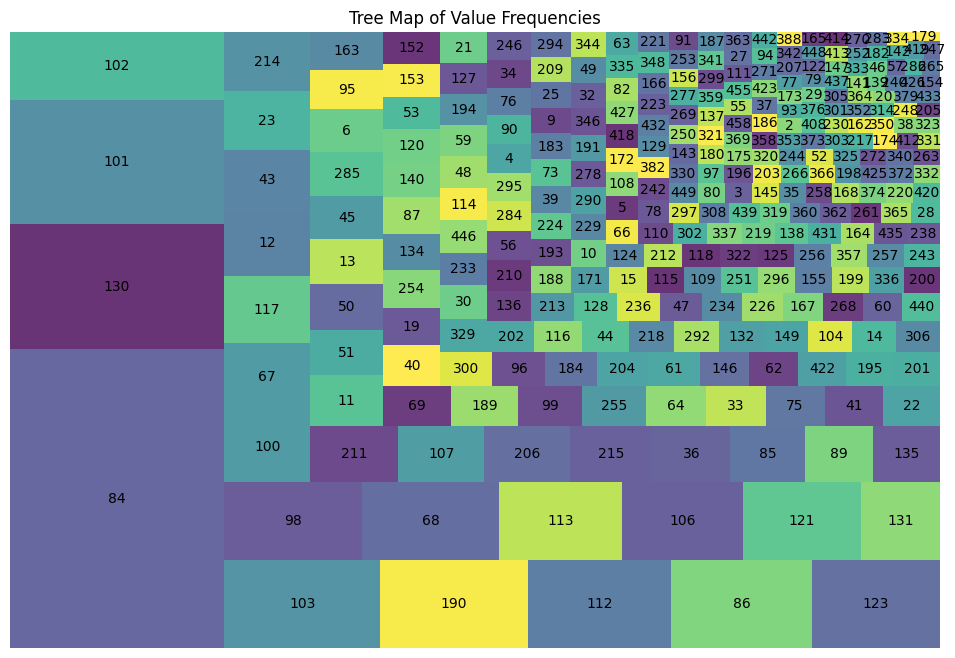

In [9]:
# Assume the column of interest is named 'category'
column_data = filtered_df['target']

# Calculate frequency of each unique value in the column
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['value', 'count']

# Plotting
plt.figure(figsize=(12, 8))
squarify.plot(sizes=value_counts['count'], label=value_counts['value'], alpha=.8)
plt.axis('off')
plt.title('Tree Map of Value Frequencies')
plt.show()

In [10]:
unique_target_count = filtered_df['target'].nunique()
print(f"The number of unique values in the 'target' column is: {unique_target_count}")

The number of unique values in the 'target' column is: 297


In [11]:
# Get the dimensions of the filtered DataFrame (rows, columns)
filtered_df_shape = filtered_df.shape

# Print the dimensions of the DataFrame in a readable format
print(f"The filtered DataFrame has {filtered_df_shape[0]} rows and {filtered_df_shape[1]} columns.")

The filtered DataFrame has 16077 rows and 2 columns.


In [12]:
filtered_df['text'] = filtered_df['text'].apply(tranlate)

In [13]:
#filtered_df

In [14]:
train_df, valid_df = train_test_split(filtered_df,random_state = 42,train_size = 0.7, stratify = filtered_df.target.values)
test_df, valid_df = train_test_split(valid_df,random_state = 42,train_size = 0.5, stratify = valid_df.target.values)
train_df.shape, valid_df.shape, test_df.shape

((11253, 2), (2412, 2), (2412, 2))

In [15]:
# Calculate class weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df['target']),
    y=train_df['target']
)

In [16]:
rus = RandomUnderSampler(random_state=42)
ros = RandomOverSampler(random_state=42)
#train_df, _ = rus.fit_resample(train_df,train_df['target'] )
train_df.shape

(11253, 2)

In [17]:
with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices((train_df['text'].values, train_df['target'].values))
    valid_data = tf.data.Dataset.from_tensor_slices((valid_df['text'].values,valid_df['target'].values))
    

In [18]:
for text, label in train_data.take(10):
    print(text)
    print(label)

tf.Tensor(b'business consultant project management, ict, quality management, consultant, maintenance engineer consultancy', shape=(), dtype=string)
tf.Tensor(101, shape=(), dtype=int64)
tf.Tensor(b'PhD candidate research, reading, writing, presenting, arguing university', shape=(), dtype=string)
tf.Tensor(84, shape=(), dtype=int64)
tf.Tensor(b'department manager sales clothing all-round', shape=(), dtype=string)
tf.Tensor(284, shape=(), dtype=int64)
tf.Tensor(b'teacher teaching, checking, designing assignments, setting up a secondary school curriculum', shape=(), dtype=string)
tf.Tensor(86, shape=(), dtype=int64)
tf.Tensor(b'business consultancy trainee consultant, it, execution, advies, strategie consultancy', shape=(), dtype=string)
tf.Tensor(101, shape=(), dtype=int64)
tf.Tensor(b'doctor researcher patient contact, analyze and write, endoscopy hospital', shape=(), dtype=string)
tf.Tensor(68, shape=(), dtype=int64)
tf.Tensor(b'lawyer creating procedural documents, correspondence with

## Download Bert model from Tensorflow HUB

In [19]:
# Get all unique target classes
label_list = train_df['target'].unique().tolist()
num_classes = len(label_list)
max_seq_length       = 128
train_batch_size     = 32


In [20]:
import kagglehub #!pip install kagglehub

# Download selected version
bert_layer = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-l-12-h-768-a-12/1",
                            trainable=True)

In [21]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file,do_lower_case)

In [22]:
print(tokenizer.wordpiece_tokenizer.tokenize("i live in eindhoven and work in tilburg"))

['i', 'live', 'in', 'ein', '##dh', '##oven', 'and', 'work', 'in', 'til', '##burg']


In [23]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize("i live in eindhoven and work in tilburg"))

[1045, 2444, 1999, 16417, 16425, 25592, 1998, 2147, 1999, 18681, 4645]

# Tokenize and preprocess

In [24]:
example = classifier_data_lib.InputExample(guid=None,
                                           text_a="i live in eindhoven and work in tilburg",
                                           text_b=None,
                                           label=110)
feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
print((feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id))

([101, 1045, 2444, 1999, 16417, 16425, 25592, 1998, 2147, 1999, 18681, 4645, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [25]:
def get_feature(text, label, label_list =label_list, max_seq_length = max_seq_length, tokenizer = tokenizer):
    example = classifier_data_lib.InputExample(guid=None,
                                              text_a = text.numpy(),
                                              text_b = None,
                                              label = label.numpy())
    feature = classifier_data_lib.convert_single_example(0,example,label_list,max_seq_length, tokenizer)
    
    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)
    

In [26]:
def get_feature_map(text,label):
    input_ids, input_mask,segment_ids,label_id = tf.py_function(get_feature, inp = [text,label],
                                                            Tout = [tf.int32, tf.int32,tf.int32,tf.int32])
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])
    
    x = { 'input_word_ids':input_ids,
     'input_mask':input_mask,
     'input_type_ids':segment_ids 
    }
    
    return (x,label_id)

# Input pipeline

In [27]:
with tf.device('/cpu:0'):
    train_data = (train_data.map(get_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE)
    .shuffle(1000)
    .batch(32,drop_remainder = True)
    .prefetch(tf.data.experimental.AUTOTUNE))
    
    
    valid_data = (valid_data.map(get_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE)
    .batch(32,drop_remainder = True)
    .prefetch(tf.data.experimental.AUTOTUNE))
    

In [28]:
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [29]:
valid_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

# Add classification head

In [30]:
def create_model():
    
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="input_type_ids")
    print(input_type_ids)
    print(type(input_type_ids))
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    drop =  tf.keras.layers.Dropout(0.5)(pooled_output)
    output = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = "output")(drop)
    
    model = tf.keras.Model(
    inputs = { 'input_word_ids':input_word_ids,
     'input_mask':input_mask,
     'input_type_ids':input_type_ids 
    },
    outputs = output)
    
    return model

In [31]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.int32, name='input_type_ids'), name='input_type_ids', description="created by layer 'input_type_ids'")
<class 'keras.src.engine.keras_tensor.KerasTensor'>
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []      

In [32]:
tf.keras.utils.plot_model(model = model, show_shapes=True,dpi= 76) #!pip install pydo

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [33]:
def plot_graphs(history,metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel('Epochs')
    plt.ylabel('metric')
    plt.legend()
    plt.show()

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint

epochs = 25

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to be monitored
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',  # Filepath to save the model file
    monitor='val_loss',  # Metric to be monitored
    save_best_only=True,  # Only save the model if the monitored metric has improved
    verbose=1)             # Verbosity mode


class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
history = model.fit(train_data, 
                    validation_data=valid_data,
                    epochs = epochs,
                    verbose =1,
                    class_weight=class_weight_dict,
                     callbacks=[early_stopping, model_checkpoint]
                   )

Epoch 1/25



351/351 [==============================] - ETA: 0s - loss: 9.9032 - sparse_categorical_accuracy: 0.2294
Epoch 1: val_loss improved from inf to 3.58858, saving model to best_model.h5


C:\Users\CentERdata\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


351/351 [==============================] - 988s 3s/step - loss: 9.9032 - sparse_categorical_accuracy: 0.2294 - val_loss: 3.5886 - val_sparse_categorical_accuracy: 0.3600
Epoch 2/25
351/351 [==============================] - ETA: 0s - loss: 6.8068 - sparse_categorical_accuracy: 0.4112
Epoch 2: val_loss improved from 3.58858 to 2.91647, saving model to best_model.h5
351/351 [==============================] - 976s 3s/step - loss: 6.8068 - sparse_categorical_accuracy: 0.4112 - val_loss: 2.9165 - val_sparse_categorical_accuracy: 0.4546
Epoch 3/25
351/351 [==============================] - ETA: 0s - loss: 5.1828 - sparse_categorical_accuracy: 0.5120
Epoch 3: val_loss improved from 2.91647 to 2.57022, saving model to best_model.h5
351/351 [==============================] - 976s 3s/step - loss: 5.1828 - sparse_categorical_accuracy: 0.5120 - val_loss: 2.5702 - val_sparse_categorical_accuracy: 0.5142
Epoch 4/25
351/351 [==============================] - ETA: 0s - loss: 3.9965 - sparse_categorica

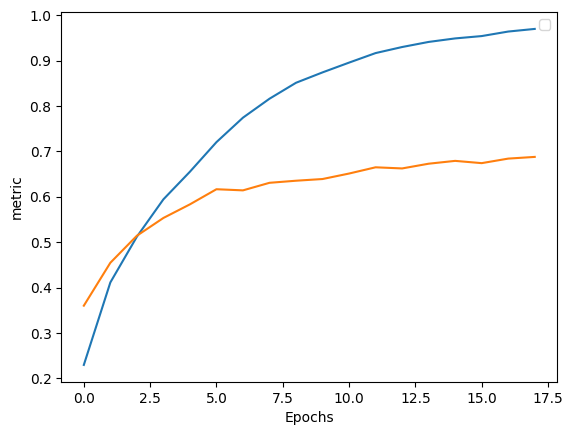

In [35]:
plot_graphs(history,'sparse_categorical_accuracy')

In [40]:
dummy_label = 100
# Define a function to preprocess the new data
def get_feature_new(text, max_seq_length, tokenizer, dummy_label):
    example = classifier_data_lib.InputExample(guid=None,
                                               text_a=text.numpy().decode('utf-8'),
                                               text_b=None,
                                               label=dummy_label)  # Use a valid dummy label
    feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
    return feature.input_ids, feature.input_mask, feature.segment_ids

def get_feature_map_new(text):
    input_ids, input_mask, segment_ids = tf.py_function(
        lambda text: get_feature_new(text, max_seq_length, tokenizer, dummy_label),
        inp=[text],
        Tout=[tf.int32, tf.int32, tf.int32]
    )
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    
    x = {'input_word_ids': input_ids,
         'input_mask': input_mask,
         'input_type_ids': segment_ids}
    
    return x

def preprocess_new_data(texts):
    dataset = tf.data.Dataset.from_tensor_slices((texts,))
    dataset = dataset.map(get_feature_map_new,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(32, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

In [41]:

# Preprocess the new data
sample_example = test_df['text'].to_list()
new_data_dataset =  preprocess_new_data(sample_example)
# Make predictions on the new data
predictions = model.predict(new_data_dataset)

# Decode the predictions
predicted_classes = [label_list[np.argmax(pred)] for pred in predictions]

print(predicted_classes)
highest_probabilities = [max(instance) for instance in predictions]
decoded_labels = label_encoder.inverse_transform(predicted_classes)

76/76 [==============================] - 64s 836ms/step
[101, 84, 14, 134, 68, 214, 366, 256, 140, 99, 101, 149, 69, 130, 213, 278, 253, 84, 68, 84, 130, 102, 211, 130, 13, 268, 190, 121, 130, 84, 101, 61, 166, 33, 382, 99, 138, 13, 84, 68, 103, 101, 296, 33, 19, 195, 113, 96, 123, 455, 98, 153, 214, 112, 44, 130, 33, 214, 255, 40, 84, 194, 102, 101, 130, 84, 433, 189, 84, 102, 27, 84, 336, 134, 84, 68, 23, 285, 73, 114, 102, 43, 68, 84, 98, 123, 86, 73, 51, 84, 164, 84, 211, 49, 84, 195, 76, 43, 113, 130, 130, 12, 346, 213, 67, 130, 198, 138, 102, 53, 130, 43, 130, 102, 112, 121, 319, 87, 68, 48, 130, 342, 84, 323, 69, 101, 190, 43, 103, 186, 121, 131, 103, 101, 123, 99, 40, 234, 348, 98, 103, 9, 84, 43, 130, 130, 250, 89, 12, 68, 101, 50, 101, 84, 167, 117, 190, 121, 135, 84, 130, 131, 76, 43, 98, 121, 13, 130, 50, 135, 36, 131, 106, 120, 215, 25, 219, 214, 254, 362, 69, 101, 130, 201, 23, 446, 68, 215, 84, 6, 255, 373, 84, 36, 256, 84, 95, 103, 84, 87, 112, 121, 168, 211, 68, 101, 6

In [42]:
test_df['prob'] = highest_probabilities
test_df['predicted_isco'] = predicted_classes

In [43]:
from sklearn.metrics import accuracy_score, f1_score
def evaluate_predictions(temp_df):
    y_pred = temp_df['predicted_isco']
    y_true = temp_df['target']
    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)

for p in [0,0.2,0.4, 0.5,0.6,0.8,0.9,0.95,0.999]:
    temp_df = test_df[test_df.prob>p]
    print("% age of data", len(temp_df)*100/len(test_df),' and set threshold probability is' ,p)
    evaluate_predictions(temp_df)

% age of data 100.0  and set threshold probability is 0
Accuracy: 0.6699834162520729
F1 Score: 0.6487061300487569
% age of data 91.66666666666667  and set threshold probability is 0.2
Accuracy: 0.7168701944821347
F1 Score: 0.6956597051403671
% age of data 81.88225538971808  and set threshold probability is 0.4
Accuracy: 0.7635443037974684
F1 Score: 0.7419164532829583
% age of data 77.40464344941957  and set threshold probability is 0.5
Accuracy: 0.786823781467595
F1 Score: 0.7656656895045757
% age of data 73.13432835820896  and set threshold probability is 0.6
Accuracy: 0.8049886621315193
F1 Score: 0.7845132208500883
% age of data 63.80597014925373  and set threshold probability is 0.8
Accuracy: 0.8440545808966862
F1 Score: 0.8270765081939055
% age of data 55.472636815920396  and set threshold probability is 0.9
Accuracy: 0.8781763826606876
F1 Score: 0.8613578733160367
% age of data 48.424543946932005  and set threshold probability is 0.95
Accuracy: 0.9058219178082192
F1 Score: 0.89022

In [44]:
test_df['target_isco'] =label_encoder.inverse_transform(test_df.target)
test_df['predicted_isco_decoded'] =label_encoder.inverse_transform(test_df.predicted_isco)